# QDAE (Quantized Distribution Auto Encoder)
Basic question: Can we learn latent variable probability distribution?

Here we have a vector value AE 
x -> qd(h) -> x_bar

qd(h) is a quantized probability distribution of the latent variable h
x_bar is output of the network, trained to be same as x

* Regularizer: smoothness encourages qd(h) to be smooth, i.e. low variance
* Regularizer: Sum to 1, encourages qd(h) to be a probability distribution
* Regularizer: use all elements of resolution across samples, encourages samples to be spread across elements of qd(h), rather than using only a few elements, i.e. x_bar=f(qd(h)_i) expresses output as a function of a single element in qd(h)
* Use tanh instead of sigmoid for better contrast

## New in 05

* MNIST

## Moving off for now..
It seems unlikely that smooth latent representation should be possible for individual sample images.

If we used movie frames in sequence and put a regularizer that encourages similar latent representation for consequtive frames, we might end up with smoothly and monotonically varying representation, e.g. for line angle.

But then why did smooth activation was seen in LISSOM that trained on sample images that were not in video sequence? To investigate that, I am going to try implementing LISSOM like laterally connected layer. I think it can be done using excitatory and inhibitory copy layers. See folder for that.


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
!pip install tqdm
!pip install dotmap

from dotmap import DotMap
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.stats import norm

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

# from google.colab import drive
# drive.mount('/content/gdrive')
# save_path_prefix = '/content/gdrive/My Drive/Colab Notebooks/saved/QDL_01'

In [0]:
def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader


def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)

def show_image_grid(images, vmin=0, vmax=1, nrows=None, ncols=None, fig_width=30):
  s = images.shape

  assert len(s) == 3
  
  if nrows is None or ncols is None:
    resolution = int(s[0] ** 0.5)
    nrows = resolution
    ncols = resolution

  assert images.shape[0] == nrows * ncols, f"{images.shape[0]} != {nrows} * {ncols}"

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_width * nrows / ncols),
                        subplot_kw={'xticks': [], 'yticks': []})

  fig.subplots_adjust(left=0.03, right=0.97, hspace=0, wspace=0)

  axs = axs.flat
  for i in np.arange(s[0]):
    axs[i].axis("off")
    axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma, aspect='auto')

  plt.tight_layout()
  plt.show()

# Creates pdf for each item
# (input_count, feature_count, height, width) => (input_count, feature_count * resolution, height, width)
def to_pdf(mu, var, resolution=10):
  mu_shape = mu.shape
  input_count, feature_count, height, width = mu_shape
  step = 1.0 / (resolution + 1)

  assert mu_shape == var.shape
  assert resolution > 0
  assert resolution < 50
  
  # mu and logvar: move features to the end and flatten
  print("to_pdf: mu", mu.shape)
  mu_combined = mu.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: mu_combined", mu_combined.shape)

  var = torch.clamp(var, step * 0.005, 3.0)
  
  var_combined = var.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: var_combined", var_combined.shape)

  # pdf for each item
  rr = np.arange(step, 1, step)
  pdfs = []
  for i in np.arange(mu_combined.shape[0]):
    pdf = norm.pdf(rr, mu_combined[i], var_combined[i])
    pdf = pdf / pdf.sum()
    pdfs.append(pdf)
  
  mu__ = torch.as_tensor(pdfs)
  print("to_pdf: mu__", mu__.shape) # (*, resolution)

  mu__ = mu__.view(-1, feature_count, resolution)
  print("to_pdf: mu__", mu__.shape) # (*, feature_count, resolution)
  
  mu__ = mu__.view(input_count, height, width, feature_count * resolution).contiguous()
  print("to_pdf: mu__", mu__.shape) # (input_count, height, width, feature_count * resolution)

  #mu__ = mu__.permute(0, 3, 1, 2).contiguous() # (input_count, feature_count * resolution, height, width)
  #print("to_pdf: mu__", mu__.shape)
  
  return mu__

# plt.plot(to_pdf(torch.tensor([[[[0.49]]]]), torch.tensor([[[[0.04]]]]), resolution=40).reshape(-1, 1).numpy())

def sample_from_pdf(pdf):
    assert pdf.shape == (resolution, )
    #print("pdf ", pdf)

    sum_pdf = sum(pdf)
    #print("sum_pdf ", sum_pdf)

    if sum_pdf > 0:
        v = random.random()
        #print("v ", v)

        s = 0
        index = 0
        while s < v and index < resolution:
          s += pdf[index] / sum_pdf
          index += 1
          #print("  s ", s)
          #print("  index ", index)
          
        # apply scale (conflates value and confidence!)
        return [(index - 1) * sum_pdf / resolution]
    else:
        return [0]


def sample_from_images__(images__):
    assert len(images__.shape) == 3

    # reshape images__ from (image count, height, width*resolution) into (image count*height*width, resolution)
    s = images__.shape
    flattened_images__ = images__.view(s[0], s[1], int(s[2] / resolution), resolution)
    s = flattened_images__.shape
    flattened_images__ = flattened_images__.view(s[0] * s[1] * s[2], s[3])

    # sample single value from each distributions into (image count*height*width, 1)
    sampled_pixels = torch.Tensor([sample_from_pdf(item.cpu().numpy()) for item in flattened_images__])

    # reshape back into (image count, height, width)
    sampled_images = sampled_pixels.view(s[0], s[1], s[2])

    return sampled_images


def averaged_sample_from_images__(images__, count=10):
    sampled_images = torch.stack([sample_from_images__(images__) for i in range(count)])
    return sampled_images.mean(dim=0)

## Train
Use x values in the range 0-1

In [0]:
# x -> QD(x) -> x_bar
# Quantized distribution auto encoder
class QDAE(nn.Module):
  def __init__(self, input_output_size, hidden_size, latent_feature_count, resolution):
    super(QDAE, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)

    self.input_output_size = input_output_size
    self.hidden_size = hidden_size
    self.latent_feature_count = latent_feature_count
    self.resolution = resolution

    self.enc1 = nn.Linear(input_output_size,  hidden_size*8)
    self.enc2 = nn.Linear(hidden_size*8, hidden_size*4)
    self.enc3 = nn.Linear(hidden_size*4, hidden_size)
    self.enc4 = nn.Linear(hidden_size, latent_feature_count * resolution)
    
    #assert latent_feature_count == 1, "TODO: 1 qd_to_features layer per latent feature"
    #self.qd_to_features = nn.Linear(latent_feature_count * resolution, latent_feature_count)
    
    self.dec1 = nn.Linear(latent_feature_count * resolution, hidden_size * 4)
    self.dec2 = nn.Linear(hidden_size * 4, input_output_size)
    
    self.monotonic = torch.sigmoid(torch.linspace(0, 1, self.resolution)).unsqueeze(dim=1)
    self.dropout = nn.Dropout(0.5)

  def encode(self, x):
    x = self.dropout(x)

    x = self.enc1(x)
    x = F.relu(x)

    x = self.enc2(x)
    x = F.relu(x)

    x = self.enc3(x)
    x = F.relu(x)

    x = self.enc4(x)
    x = torch.tanh(x) * 0.5 + 0.5
    return x
    
  def decode(self, qd_h):
    y = self.dec1(qd_h)
    y = F.relu(y)
    y = self.dec2(y)
    x_bar = F.sigmoid(y)
    return x_bar
    
  def forward(self, x):
    self.logger.debug(f"x {x.shape}")
    qd_h = self.encode(x)
    
    # force smaller x to use smaller indices and larger x use larger indices.
    # Use this in conjunction with regularizing
    #h = qd_h @ self.monotonic
    
    # Tried using a layer to connect qd_h with h, but doesn't seem to do much
    #qd_h_scaled = qd_h * self.monotonic
    #h = self.qd_to_features(qd_h)
    
    # Sample from PDF
    #h = torch.tensor([sample_from_pdf(pdf) for pdf in qd_h])
    
    x_bar = self.decode(qd_h)
    return qd_h, x_bar
  
def train(model, device, X, optimizer, epochs, log_interval):
  model.train()
  X = X.to(device)
  #print("X", X)
  for epoch in range(epochs):
    optimizer.zero_grad()
    qd_h, X_bar = model(X)
    #print("output", output)
    loss = F.mse_loss(X_bar, X)
    
    # smoothness
    loss += (qd_h[:, 0:-1] - qd_h[:, 1:]).pow(2).mean().pow(0.5) * 0.1
    
    # should sum to 1
    loss += (qd_h.sum(dim=1) - 1).pow(2).mean().pow(0.5) * 0.1
    
    # use all elements of resolution across samples
    use_count = qd_h.sum(dim=0)
    avg_use = use_count.mean()
    err = (use_count - avg_use).pow(2).sum().pow(0.5) / resolution
    loss += err * 0.1
    
    # sparse use = values near 0.5 are discouraged. encourage more contrast, i.e
    # values near 0 and 1.
    #loss += (0.5 - (qd_h - 0.5).abs()).mean() * 0.1
    
    loss.backward()
    optimizer.step()
    if epoch % log_interval == 0:
      print(f"Epoch: {epoch} \t Loss: {loss.item():.6f}")
      show_image(qd_h.detach(), title="qd_h", print_values=False)
      show_image_grid(X_bar[0:9,:].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
      if loss < 0.0001:
        break

Epoch: 0 	 Loss: 0.815795


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


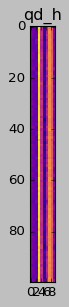

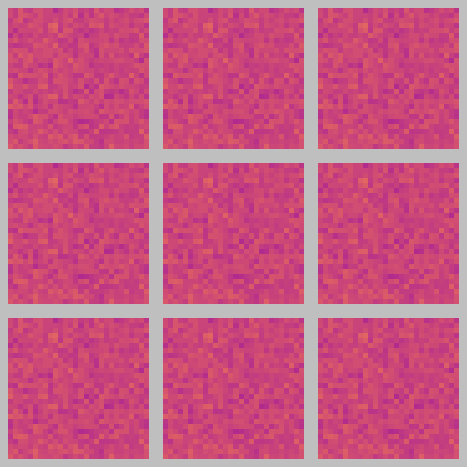

Epoch: 1000 	 Loss: 0.085422


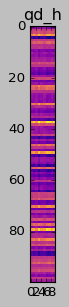

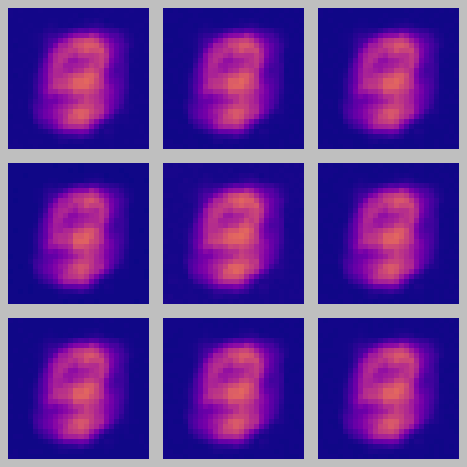

In [0]:
resolution = 10

X = next(iter(load_mnist(batch_size=100)))[0].squeeze(dim=1).view(100, -1).float()

model = QDAE(input_output_size=X.shape[-1], hidden_size=resolution, latent_feature_count=1, resolution=resolution)

#for param in model.parameters():
    # print(type(param.data), param.size())
    #nn.init.constant(param.data, val=0.1)
    #param.data += 0.1
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, device=device, X=X, optimizer=optimizer, epochs=10000, log_interval=1000)

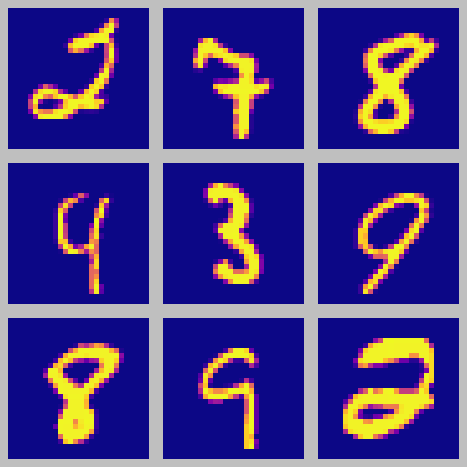

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


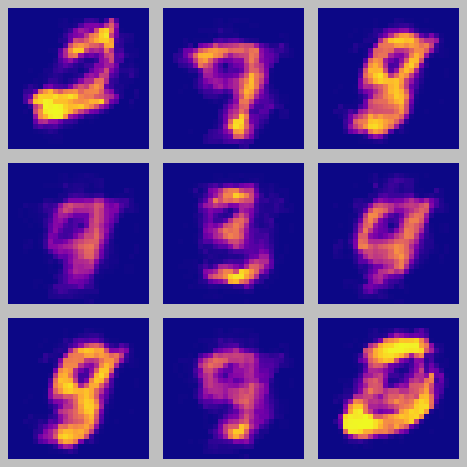

In [0]:
show_image_grid(X[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
qd_h, X_bar = model(X[0:9])
show_image_grid(X_bar.view(-1,28,28), nrows=3, ncols=3, fig_width=6)

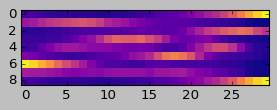

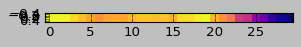

[[0.04587507 0.04573214 0.04529116 0.04241595 0.04004124 0.03671613
  0.03455147 0.03623953 0.03719306 0.03679326 0.03916773 0.04040599
  0.04037613 0.0400216  0.0402526  0.03795284 0.04307345 0.04300159
  0.04460365 0.04591173 0.03883496 0.03457943 0.03146011 0.02245143
  0.02060646 0.01398468 0.01045245 0.00416097 0.00144258 0.00083038]]


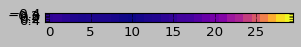

[[0.01275972 0.01392663 0.01173684 0.00885758 0.00806478 0.00834799
  0.0082913  0.00845274 0.00746301 0.00603205 0.00523257 0.00692281
  0.00842619 0.00928098 0.01231587 0.01359245 0.01763305 0.01846015
  0.02281407 0.02853671 0.03359291 0.03790706 0.04624808 0.05163631
  0.06228191 0.07371029 0.08967093 0.10479054 0.11869466 0.1266824 ]]


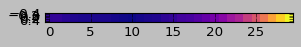

[[0.01268452 0.01347965 0.01091045 0.00827146 0.00728241 0.00763163
  0.00740981 0.00763431 0.00635833 0.00540265 0.00483635 0.00638804
  0.00762564 0.00843945 0.01183602 0.0132136  0.01780841 0.01946715
  0.02295581 0.02825809 0.03384912 0.0396938  0.04727036 0.05248606
  0.06351656 0.07422286 0.08844665 0.1035783  0.11757797 0.13000995]]


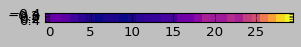

[[0.02931739 0.02982938 0.028514   0.02563676 0.02405301 0.02253206
  0.02142139 0.02234614 0.02232803 0.02141266 0.02220015 0.0236644
  0.02440116 0.02465129 0.02628423 0.02577265 0.03035325 0.03073087
  0.03370886 0.03722422 0.03621393 0.03624325 0.03885409 0.03704387
  0.04144418 0.04384749 0.05006169 0.05447575 0.06006862 0.06375639]]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


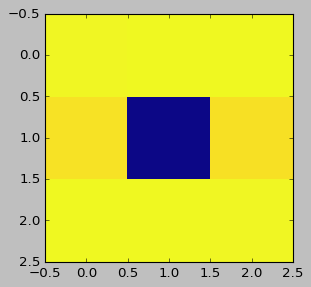

In [0]:
# latent vector arithmatic
show_image(qd_h.detach(), print_values=False)
qd = (qd_h[7] + qd_h[8]) / 2
qd = qd.unsqueeze(dim=0)
show_image(qd_h[7].unsqueeze(dim=0).detach(), print_values=True)
show_image(qd_h[8].unsqueeze(dim=0).detach(), print_values=True)

show_image(qd_h[0].unsqueeze(dim=0).detach(), print_values=True)
show_image(qd.detach(), print_values=True)
y_bar = model.decode(qd_h[0])
show_image(y_bar.view(3,3).detach())


to_pdf: mu torch.Size([1, 1, 1, 25])
to_pdf: mu_combined (25,)
to_pdf: var_combined (25,)
to_pdf: mu__ torch.Size([25, 30])
to_pdf: mu__ torch.Size([25, 1, 30])
to_pdf: mu__ torch.Size([1, 1, 25, 30])
torch.Size([25, 30])


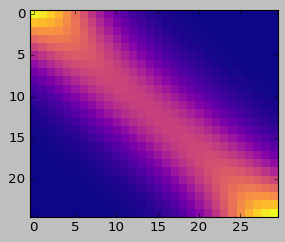

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


y_bar torch.Size([25, 9])


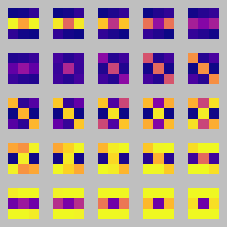

In [0]:
dr = 5
c = 5
mu = torch.tensor(np.linspace(0, 1, r * c)).unsqueeze(0).unsqueeze(0).unsqueeze(0).float()
var = torch.ones(mu.shape).float() * 0.2

y = to_pdf(mu, var, resolution=resolution).squeeze().float()
print(y.shape)
show_image(y)
y_bar = model.decode(y)
print("y_bar", y_bar.shape)
show_image_grid(y_bar.view(-1,3,3), nrows=r, ncols=c, fig_width=3)